## Notebook to evaluate tomography reconstruction schemes

### Imports/Function definitions

In [1]:
import matplotlib.pyplot as plt                 # For normal plotting
from mpl_toolkits.mplot3d import proj3d         # For 3D plotting
import numpy as np                              # For maths
from scipy import ndimage                       # For image rotations
from scipy import optimize                      # For function minimization
import astra                                    # For tomography framework
import copy                                     # For deep copying arrays

import RegTomoReconMulti as rtr                 # Modified version of Rob's CS code
import multi_axis                               # My custom functions

Compilation successful


In [7]:
def phantom_error(beta,recon,P):
    a = np.linalg.norm(recon*beta-P)
    b = np.linalg.norm(P)
    return a/b

In [137]:
def generate_angles(x_tilt = (-70,70,11), y_tilt = None, n_random = 0):
    """ Return a list of [ax,ay,az] lists, each corresponding to axial
    rotations applied to [0,0,1] to get a new projection direction.
    
    To include tilt series about x or y, 
    specify _tilt with (min_angle, max_angle, n_angles) in deg for
    a linear spacing of angles, set to None if not desired. 
    
    Add n_random tilt orientations with angle chosen between +-90, 
    or set to 0 for none."""
    
    angles = []
    ax,ay,az = 0,0,0
    
    # x series
    if x_tilt != None:
        for ax in np.linspace(x_tilt[0],x_tilt[1],x_tilt[2]):
            angles.append([ax,ay,az])
    
    # y series
    ax,ay,az = 0,0,0
    if y_tilt != None:
        for ay in np.linspace(y_tilt[0],y_tilt[1],y_tilt[2]):
            angles.append([ax,ay,az])
    
    # random series
    if n_random > 0:
        for i in range(n_random):
            as_rand = np.random.rand(3)*180 - 90
            angles.append(as_rand.tolist())
    
    return angles

def generate_proj_data(P,angles):
    """ Returns projection dataset given phantom P
    and 3D projection angles list.
    
    Output is normalised and reshaped such that the
    projection slice dimension is in the middle, so as
    to be compatible with astra."""
    P_projs = []
    
    for [ax,ay,az] in angles:
        P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
        P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
        P_projs.append(P_rot_proj)
        
    # Prepare projections for reconstruction
    raw_data = np.array(P_projs)
    raw_data = raw_data -  raw_data.min()
    raw_data = raw_data/raw_data.max()
    raw_data = np.transpose(raw_data,axes=[1,0,2]) # reshape so z is middle column
        
    return raw_data
      
def generate_vectors(angles):
    """ Converts list of 3D projection angles into
    list of astra-compatible projection vectors,
    with [r,d,u,v] vectors on each row. """
    vectors = []
    for [ax,ay,az] in angles:
        vector = multi_axis.get_astravec(ax,ay,az)
        vectors.append(vector)
    
    return vectors

def generate_reconstruction(raw_data,vectors, algorithm = 'SIRT3D_CUDA', niter=10, weight = 0.01,
                            balance = 1, steps = 'backtrack'):

    # Astra default algorithms
    if algorithm in ['SIRT3D_CUDA','FP3D_CUDA','BP3D_CUDA','CGLS3D_CUDA']:
        # Load data objects into astra C layer
        proj_geom = astra.create_proj_geom('parallel3d_vec',np.shape(raw_data)[0],np.shape(raw_data)[2],np.array(vectors))
        projections_id = astra.data3d.create('-sino', proj_geom, raw_data)
        vol_geom = astra.creators.create_vol_geom(np.shape(raw_data)[0], np.shape(raw_data)[0],
                                                  np.shape(raw_data)[2])
        reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
        alg_cfg = astra.astra_dict(algorithm)
        alg_cfg['ProjectionDataId'] = projections_id
        alg_cfg['ReconstructionDataId'] = reconstruction_id
        algorithm_id = astra.algorithm.create(alg_cfg)

        astra.algorithm.run(algorithm_id,iterations=niter)
        recon = astra.data3d.get(reconstruction_id)
    
    # CS TV using RTR
    if algorithm == 'TV1':
        data = rtr.tomo_data(raw_data, np.array(vectors), degrees=True,
                    tilt_axis=0, stack_dim=1)

        vol_shape = (data.shape[0],data.shape[0],data.shape[2])
        projector = data.getOperator(vol_shape=vol_shape,
                                    backend='astra',GPU=True)
        alg = rtr.TV(vol_shape, order=1)
        
        recon = alg.run(data=data,op=projector, maxiter=niter, weight=weight,
                balance=balance, steps=steps,
                callback=None)
    
    return recon

def reorient_reconstruction(r):
    # Swap columns back to match orientation of phantom
    r = np.transpose(r,[2,1,0]) # Reverse column order
    r = r[:,::-1,:] # Reverse the y data
    r = r -  r.min() # normalise
    r = r/r.max()

    recon_vector = copy.deepcopy(r)
    
    return recon_vector


### Full example

In [ ]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_tri_pris()

# View in 2D
multi_axis.plot_2d(X,Y,Z,P)

# Rotate 90 about +x and view again
Pr = multi_axis.rotate_bulk(P,50,0,0)
multi_axis.plot_2d(X,Y,Z,Pr)

In [3]:
# Generate projection data
angles = multi_axis.generate_angles()
raw_data = multi_axis.generate_proj_data(P,angles)
vectors = multi_axis.generate_vectors(angles)

In [9]:
# Perform reconstruction
recon = multi_axis.generate_reconstruction(raw_data,vectors,algorithm='SIRT3D_CUDA')

In [10]:
# Match orientation of reconstruction to phantom
recon_vector = multi_axis.reorient_reconstruction(recon)

0.7512605845443252

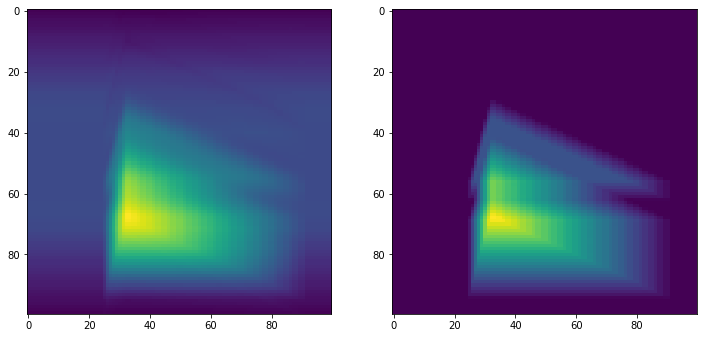

In [11]:
# Plot reconstruction
ax,ay,az = 40,0,0
a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(recon_vector,P))
opt.fun

### Testing

In [12]:
X,Y,Z,P = multi_axis.generate_tri_pris()

In [99]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

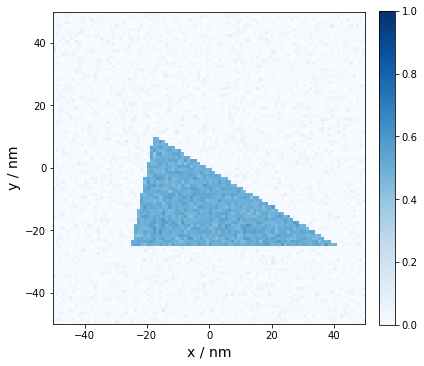

In [106]:
n = noisy('gauss',P)
multi_axis.plot_2d(X,Y,Z,n)

In [39]:
# normal angles
angles = multi_axis.generate_angles(x_tilt = (-70,70,21),y_tilt = (-70,70,21))

# alternating angles
ADA_angles = []
mid = int(len(angles)/2)
for i in range(mid):
    ADA_angles.append(angles[i])
    ADA_angles.append(angles[mid+i])
    
# random angles
rand_angles = copy.deepcopy(angles)
np.random.shuffle(rand_angles)

for i in range(len(angles)):
    print(angles[i],'\t',ADA_angles[i],'\t',rand_angles[i])
    

all_angles = [angles,ADA_angles,rand_angles]

[-70.0, 0, 0] 	 [-70.0, 0, 0] 	 [0, 49.0, 0]
[-63.0, 0, 0] 	 [0, -70.0, 0] 	 [49.0, 0, 0]
[-56.0, 0, 0] 	 [-63.0, 0, 0] 	 [35.0, 0, 0]
[-49.0, 0, 0] 	 [0, -63.0, 0] 	 [0, -63.0, 0]
[-42.0, 0, 0] 	 [-56.0, 0, 0] 	 [0, 63.0, 0]
[-35.0, 0, 0] 	 [0, -56.0, 0] 	 [0, -35.0, 0]
[-28.0, 0, 0] 	 [-49.0, 0, 0] 	 [0, -21.0, 0]
[-21.0, 0, 0] 	 [0, -49.0, 0] 	 [14.0, 0, 0]
[-14.0, 0, 0] 	 [-42.0, 0, 0] 	 [70.0, 0, 0]
[-7.0, 0, 0] 	 [0, -42.0, 0] 	 [-42.0, 0, 0]
[0.0, 0, 0] 	 [-35.0, 0, 0] 	 [-70.0, 0, 0]
[7.0, 0, 0] 	 [0, -35.0, 0] 	 [42.0, 0, 0]
[14.0, 0, 0] 	 [-28.0, 0, 0] 	 [-49.0, 0, 0]
[21.0, 0, 0] 	 [0, -28.0, 0] 	 [0, 28.0, 0]
[28.0, 0, 0] 	 [-21.0, 0, 0] 	 [0, 56.0, 0]
[35.0, 0, 0] 	 [0, -21.0, 0] 	 [-28.0, 0, 0]
[42.0, 0, 0] 	 [-14.0, 0, 0] 	 [21.0, 0, 0]
[49.0, 0, 0] 	 [0, -14.0, 0] 	 [56.0, 0, 0]
[56.0, 0, 0] 	 [-7.0, 0, 0] 	 [0, -42.0, 0]
[63.0, 0, 0] 	 [0, -7.0, 0] 	 [28.0, 0, 0]
[70.0, 0, 0] 	 [0.0, 0, 0] 	 [7.0, 0, 0]
[0, -70.0, 0] 	 [0, 0.0, 0] 	 [63.0, 0, 0]
[0, -63.0, 0] 	 [7.0, 0

In [41]:
all_raw_data = []
all_vectors = []

for i, angs in enumerate(all_angles):
    raw_data = multi_axis.generate_proj_data(P,angs)
    vectors = multi_axis.generate_vectors(angs)
    all_raw_data.append(raw_data)
    all_vectors.append(vectors)

In [42]:
all_recons = []
for i in range(3):
    recon = multi_axis.generate_reconstruction(all_raw_data[i],all_vectors[i],algorithm='SIRT3D_CUDA')
    recon_vector = multi_axis.reorient_reconstruction(recon)
    all_recons.append(recon_vector)

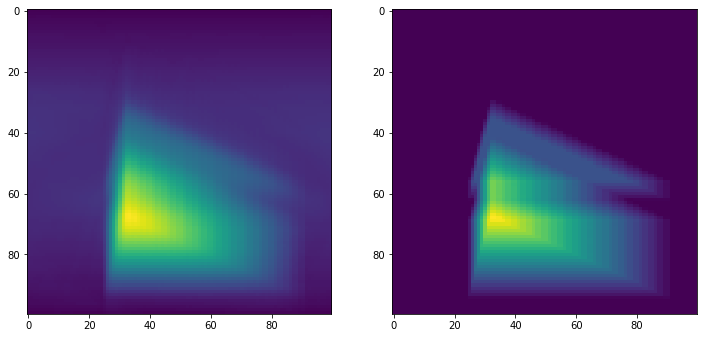

In [95]:
# Plot reconstruction
x = 2
ax,ay,az = 40,0,0
a = multi_axis.rotate_bulk(all_recons[x],ax,ay,az)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(all_recons[x],P))
e2 = opt.fun

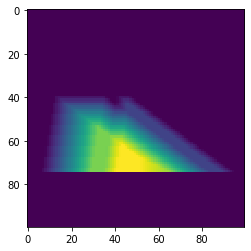

In [87]:
plt.imshow(all_raw_data[2][:,5,:])

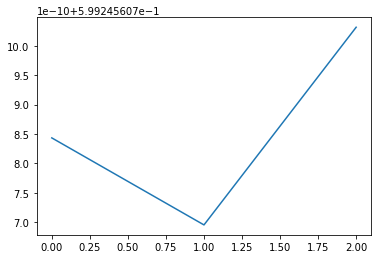

In [97]:
plt.plot([e0,e1,e2])

In [ ]:
# best recon from ada then norm then rand but by 1e-10 (x,y,21 each, no noise)